In [392]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.normal import Normal
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt


In [393]:
#Define the distribution that we will learn
data_mean = 10
data_stddev =  math.sqrt(2)
series_length = 50

Define the shape of the generator

Takes 20 random inputs and generates a distribution (as defined above)
Hidden layer neuron count is defined. 

In [394]:
#Generator shape
g_input_size = 20    

#hidden layer neuron count
g_hidden_size = 150  

g_output_size = series_length  

In [395]:
#discriminator shape

d_input_size = series_length
d_hidden_size = 75   

#output is single value where true = 1 (matches distribution) and fake = 0 (does not match distribution)
d_output_size = 1

Define two functions to return functions that provide
a true sample and some random noise. The true sample
trains the discriminator, the random noise feeds the 
generator.

Make local copies of the signal generator functions

In [396]:
def get_real_sampler(mu, sigma):
    dist = Normal( mu, sigma )
    return lambda m, n: dist.sample( (m, n) ).requires_grad_()

#returns a function with dummy m and n
def get_noise_sampler():
    #return a function that takes in m and n as outputs
    return lambda m, n: torch.rand(m, n).requires_grad_()  # Uniform-dist data into generator, _NOT_ Gaussian

# get_noise_sampler = lambda m, n: torch.rand(m, n).requires_grad_()

actual_data = get_real_sampler( data_mean, data_stddev )
noise_data  = get_noise_sampler()

Define the generator 

It's important the generator can output means that match. Be careful
using something like sigmoid, which outputs 0..1. That would not learn
something with mean 2.0 !

This network takes in noise
and produces an output.

xfer is the transfer function

In [397]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        #instantiate nn.Module object because we inherit from it (?)
        super(Generator, self).__init__()
        
        #define linear layers of give in- and output size 
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, hidden_size)
        self.map5 = nn.Linear(hidden_size, hidden_size)
        self.map6 = nn.Linear(hidden_size, output_size)
        
        #transfer function - Scaled Exponential Linear Unit (SELU)
        #selu works ok
        self.xfer = torch.nn.SELU()
        
        #relu doesn't converge
        #self.xfer = torch.nn.ReLU()
        
        #leakyReLU doesn't converge
        #self.xfer=torch.nn.LeakyReLU()

    def forward(self, x):
        #forward pass -- 
        x = self.xfer(self.map1(x))
        x = self.xfer(self.map2(x))
        x = self.xfer(self.map3(x))
        x = self.xfer(self.map4(x))
        x = self.xfer(self.map5(x))
        return self.xfer(self.map6(x))

Note the last layer should restrict to 0..1 (opposite of the generator)
This allows us more choice in loss functions.

This network is a classic multilayer perceptron - really nothing
special at all. It returns true/false based on the learned
function.

In [398]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, hidden_size)
        self.map4 = nn.Linear(hidden_size, output_size)
        self.elu = torch.nn.ELU()

    def forward(self, x):
        x = self.elu(self.map1(x))
        x = self.elu(self.map2(x))
        x = self.elu(self.map3(x))
        return torch.sigmoid( self.map4(x) )

Instantiate generator and discriminator

In [399]:
G = Generator(input_size=g_input_size, hidden_size=g_hidden_size, output_size=g_output_size)

D = Discriminator(input_size=d_input_size, hidden_size=d_hidden_size, output_size=d_output_size)


Define loss function and optimiser object for generator and discriminator and learning rates

In [400]:
criterion = nn.BCELoss()

# d_learning_rate = 5e-4
# g_learning_rate = 5e-3

d_learning_rate = 3e-3
g_learning_rate = 1e-2

# d_learning_rate = 9e-4
# g_learning_rate = 7e-4

d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=0) #, betas=optim_betas)
g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=0 ) #, betas=optim_betas)



#Adam turns out not to converge...(?????)
# d_optimizer = torch.optim.Adam(D.parameters(), lr=d_learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# g_optimizer = torch.optim.Adam(G.parameters(), lr=g_learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

This fires in real data and learns a 1.0 mapping

In [401]:
def train_D_on_actual() :
    real_data = actual_data(d_minibatch_size, d_input_size)
    decision = D(real_data)
    error = criterion(decision, torch.ones(d_minibatch_size, 1))  # ones = true
    error.backward() 

The other side of training: learn to recognize fake output from
the generator.

In [402]:
def train_D_on_generated() :
    #d_minibatch_size = m, g_input_size = n
    noise = noise_data(d_minibatch_size, g_input_size)
    
    #to get fake data simply pass noise into the generator 
    fake_data = G(noise) 
    decision = D(fake_data)
    
    error = criterion(decision, torch.zeros(d_minibatch_size, 1))  # zeros = fake
    error.backward()

The training for the generator is to assume that the generator
produces perfect data (i.e. the discriminator returns 1.0).
Then learn how to improve the output from the generator based on the discriminators actual output.

This is the key piece of a GAN:
pass the error through both networks, but only update the generators
weights.

In [403]:
def train_G():
    noise = noise_data(g_minibatch_size, g_input_size)
    fake_data = G(noise)
    fake_decision = D(fake_data)
    error = criterion(fake_decision, torch.ones(g_minibatch_size, 1) )  # we want to fool, so pretend it's all genuine

    error.backward()
    return error.item(), fake_data

The main loop, train based on loads of data.

The algo works like this:
    
Step 1 is plain old batch learning, if the rest of the code were
removed you would have a network that can identify the desired distribution

- train the discriminator just like you would train any network
- use both true and false (generated) samples to learn

Step 2 is the GAN difference
- train the generator to produce, but don't compare the output to a good sample
- feed the sample generated output through the disciminator to spot the fake
- backpropagate the error through the discriminator and the generator

So let's think about the possible cases (in *all* cases only the generators parameters 
are updated in the step 2)

*Discrimator perfect, Generator Perfect*
Generator makes a sample which is identified as 1.0. Error is 0.0, no learning occurs

*Discrimator perfect, Generator Rubbish*
Generator makes noise which is identified as 0.0. Error is 1.0, error is propagated and the generator learns

*Discrimator rubbish, Generator Perfect*
Generator makes sample which is identified as 0.0. Error is 1.0, error is propagated the generator would not learn much because the error would be absorbed by the discriminator

*Discrimator rubbish, Generator Rubbish*
Generator makes sample which is identified as 0.5. Error is 0.5, error is propagated the gradients in the discriminator and generator would mean the error is shared between both
and learning occurs

In [404]:
# Now define how to send data into the process

# There are two phases of training, train the discriminator then the generator. 
# It seems to be important that the discriminator be 'better' than the generator.
# Sometimes more batches are sent to train the discriminator than the generator.
# In this case we put more stuff into the discriminator training.


d_minibatch_size = 15 
g_minibatch_size = 10

num_epochs = 5000
print_interval = num_epochs/10


losses = []

for epoch in range(num_epochs):
    #discriminator
    #pytorch convention
    D.zero_grad()
    
    #train on actual and generated separately and THEN update step so gradients are accumulated
    train_D_on_actual()    
    train_D_on_generated()
    d_optimizer.step()
    
    #generator
    G.zero_grad()
    loss, generated = train_G()
    g_optimizer.step()
    
    
    
    losses.append(loss)
    if( epoch % print_interval) == (print_interval-1) :
        print("Epoch %6d,    Loss = %5.3f" % (epoch+1, loss))
        
    relative_change = (losses[epoch] - losses[epoch-1])/losses[epoch-1]
    
    if (relative_change <= 10^-2):
        print('Converged at epoch ' +str(epoch))
        break
        
print( "Training complete" )
# print(generated)
# print(generated.size())

Epoch    500,    Loss = 0.999
Epoch   1000,    Loss = 0.727
Epoch   1500,    Loss = 0.684
Epoch   2000,    Loss = 0.686
Epoch   2500,    Loss = 0.686
Epoch   3000,    Loss = 0.694
Epoch   3500,    Loss = 0.671
Epoch   4000,    Loss = 0.690
Epoch   4500,    Loss = 0.701
Epoch   5000,    Loss = 0.695
Training complete


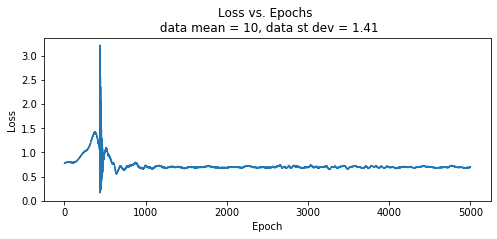

In [405]:
x=np.arange(len(losses))
plt.figure(figsize=(8,3))
plt.plot(x,losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(bottom=0)
plt.title('Loss vs. Epochs \n data mean = '+str(data_mean)+', data st dev = '+str(round(data_stddev,2)))
plt.show()

### Checking if what the GAN generates is accurate

In [406]:
demo_length = 100

#the 'generated' tensor contains the last minibatch of 10 generated samples

d = torch.empty(generated.size(0), demo_length) 

#print(generated)

In [407]:

def draw( data ) :    
    plt.figure(figsize=(10,5))
    
    #generated distributions
    generated_distributions = data.tolist() if isinstance(data, torch.Tensor) else data
    plt.plot(generated_distributions)
    
    #plt.xticks(ticks = [1, 2, 3], labels = ['0', '1', '2'])
    


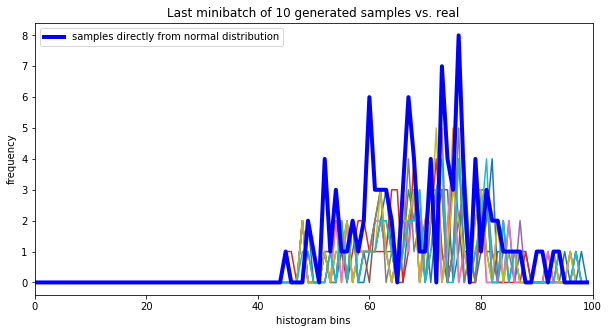

In [408]:
for i in range(0, d.size(0)) :
    d[i] = torch.histc(generated[i], min=0, max=data_mean+3*data_stddev, bins=demo_length)

# .t() method transposes the 2 dimensional tensor
draw( d.t() )

#plotting normal distribution with correct parameters for reference
original=torch.empty(demo_length).normal_(mean=data_mean,std=data_stddev)
original_histogram = torch.histc( original, min=0, max=data_mean+3*data_stddev, bins=demo_length )
plt.plot(original_histogram, linewidth=4, label='samples directly from normal distribution',color='blue')
plt.legend()
plt.title('Last minibatch of 10 generated samples vs. real')
plt.xlabel('histogram bins')
plt.ylabel('frequency')
plt.xlim((0, demo_length)) 

plt.show()

In [409]:
mean = torch.mean(generated, dim=0)
std_devs = mean.std(dim=0)

avg_mean = torch.mean(mean, dim=0)
mean_std_dev = std_devs.mean(dim=0)

print('GAN:      mean = ' + str(round(avg_mean.item(),3)) +    '    |  st dev = ' + str(round(mean_std_dev.item(),3)))
print('REAL:     mean = ' + str(data_mean)                + '      |  st dev = ' + str(round(data_stddev,3)))
print('% ERROR:         ' + str( round(100*((avg_mean.item()-data_mean)/data_mean),2) ) +'%   |          '+str( round(100*((mean_std_dev.item()-data_stddev)/data_stddev),1) ) +'%')

GAN:      mean = 10.051    |  st dev = 1.55
REAL:     mean = 10      |  st dev = 1.414
% ERROR:         0.51%   |          9.6%
